In [1]:
# Imports
import numpy as np
from PIL import Image
import requests
from io import BytesIO
from tqdm import tqdm

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b

Using TensorFlow backend.


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Hyperparams
ITERATIONS = 20
CHANNELS = 3
IMAGE_SIZE = 500
IMAGE_WIDTH = IMAGE_SIZE
IMAGE_HEIGHT = IMAGE_SIZE
IMAGENET_MEAN_RGB_VALUES = [123.68, 116.779, 103.939]
CONTENT_WEIGHT = 0.02  #0.001
STYLE_WEIGHT = 4.5  #1
TOTAL_VARIATION_WEIGHT = 0.995
TOTAL_VARIATION_LOSS_FACTOR = 1.25

In [0]:
# Paths
input_image_path = "drive/My Drive/AIschool Team4/최세영/input2.png"
style_image_path = "drive/My Drive/AIschool Team4/최세영/style2.png"


san_francisco_image_path = "https://file1.bobaedream.co.kr/multi_image/vi/2019/01/04/02/GAA5c2e4b4f76030.jpg"

tytus_image_path = "http://magazine.hankyung.com/magazinedata/images/oldfiles/money/21/072_2.jpg"

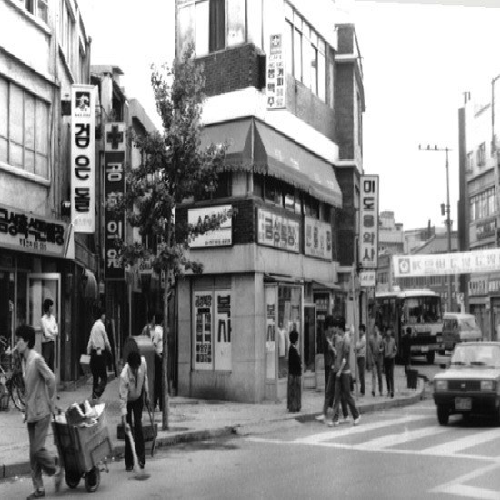

In [9]:
#Input visualization 
input_image = Image.open(BytesIO(requests.get(san_francisco_image_path).content))
input_image = input_image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
input_image.save(input_image_path)
input_image

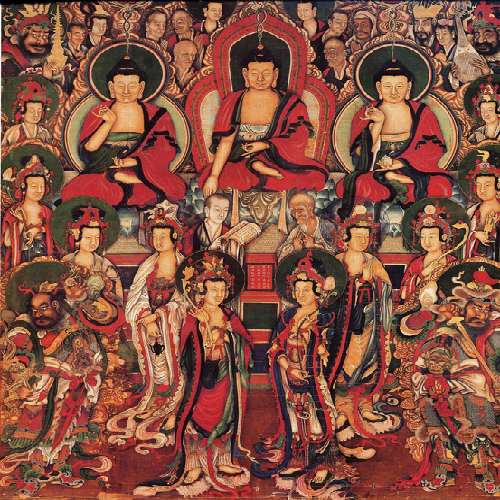

In [10]:
# Style visualization 
style_image = Image.open(BytesIO(requests.get(tytus_image_path).content))
style_image = style_image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
style_image.save(style_image_path)
style_image

In [0]:
# Data normalization and reshaping from RGB to BGR
input_image_array = np.asarray(input_image, dtype="float32")
input_image_array = np.expand_dims(input_image_array, axis=0)
input_image_array[:, :, :, 0] -= IMAGENET_MEAN_RGB_VALUES[2]
input_image_array[:, :, :, 1] -= IMAGENET_MEAN_RGB_VALUES[1]
input_image_array[:, :, :, 2] -= IMAGENET_MEAN_RGB_VALUES[0]
input_image_array = input_image_array[:, :, :, ::-1]

style_image_array = np.asarray(style_image, dtype="float32")
style_image_array = np.expand_dims(style_image_array, axis=0)
style_image_array[:, :, :, 0] -= IMAGENET_MEAN_RGB_VALUES[2]
style_image_array[:, :, :, 1] -= IMAGENET_MEAN_RGB_VALUES[1]
style_image_array[:, :, :, 2] -= IMAGENET_MEAN_RGB_VALUES[0]
style_image_array = style_image_array[:, :, :, ::-1]


In [12]:

# Model
input_image = backend.variable(input_image_array)
style_image = backend.variable(style_image_array)
combination_image = backend.placeholder((1, IMAGE_HEIGHT, IMAGE_SIZE, 3))

input_tensor = backend.concatenate([input_image,style_image,combination_image], axis=0)
model = VGG16(input_tensor=input_tensor, include_top=False)
model.summary()

W0816 11:29:19.376464 140497002264448 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0816 11:29:19.384788 140497002264448 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0816 11:29:19.388540 140497002264448 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0816 11:29:19.426059 140497002264448 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



58892288/58889256 [==============================] - 1s 0us/step


W0816 11:29:20.803919 140497002264448 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0816 11:29:20.804897 140497002264448 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [0]:
conv_layer = []

for layer in model.layers:
  conv_layer.append(layer.name)
  print(layer.name)

del conv_layer[0]
print(conv_layer)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
['block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_pool']


In [0]:
conv_layer=['block2_conv2', 'block3_conv1']

In [0]:
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))
  
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

def compute_style_loss(style, combination):
    style = gram_matrix(style)
    combination = gram_matrix(combination)
    size = IMAGE_HEIGHT * IMAGE_WIDTH
    return backend.sum(backend.square(style - combination)) / (4. * (CHANNELS ** 2) * (size ** 2))
  
def total_variation_loss(x):
    a = backend.square(x[:, :IMAGE_HEIGHT-1, :IMAGE_WIDTH-1, :] - x[:, 1:, :IMAGE_WIDTH-1, :])
    b = backend.square(x[:, :IMAGE_HEIGHT-1, :IMAGE_WIDTH-1, :] - x[:, :IMAGE_HEIGHT-1, 1:, :])
    return backend.sum(backend.pow(a + b, TOTAL_VARIATION_LOSS_FACTOR))  

  
def evaluate_loss_and_gradients(x):
    x = x.reshape((1, IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
    outs = backend.function([combination_image], outputs)([x])
    loss = outs[0]
    gradients = outs[1].flatten().astype("float64")
    return loss, gradients

class Evaluator:

    def loss(self, x):
        loss, gradients = evaluate_loss_and_gradients(x)
        self._gradients = gradients
        return loss

    def gradients(self, x):
        return self._gradients

def visualx(x):
    '''x : normalized numpy array'''
    x = x.copy()
    x = x.reshape((IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
    x = x[:, :, ::-1]
    x[:, :, 0] += IMAGENET_MEAN_RGB_VALUES[2]
    x[:, :, 1] += IMAGENET_MEAN_RGB_VALUES[1]
    x[:, :, 2] += IMAGENET_MEAN_RGB_VALUES[0]
    x = np.clip(x, 0, 255).astype("uint8")
    output_image = Image.fromarray(x)
    return output_image

In [0]:
!ls drive/My\ Drive/AIschool\ Team4/최세영/iteration_output_4/

block2_conv2  block3_conv1


In [0]:
layers = dict([(layer.name, layer.output) for layer in model.layers])


#output_image_path= []


num = 0

for i in tqdm(conv_layer):
    content_layer = str(i)
    num = num + 1
    print("trial", num, content_layer)
    
    string_name = "drive/My Drive/AIschool Team4/최세영/iteration_output_4/"+content_layer+"/output_"
    #output_image_path.append(string_name)
  
    print(string_name)

    layer_features = layers[content_layer]
    content_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]

    loss = backend.variable(0.)
    loss = loss + CONTENT_WEIGHT * content_loss(content_image_features,
                                          combination_features)

    style_layers = ["block1_conv2", "block2_conv2", "block3_conv3", "block4_conv3", "block5_conv3"]
    for layer_name in style_layers:
        layer_features = layers[layer_name]
        style_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        style_loss = compute_style_loss(style_features, combination_features)
        loss = loss + (STYLE_WEIGHT / len(style_layers)) * style_loss
       
      

    loss = loss + TOTAL_VARIATION_WEIGHT * total_variation_loss(combination_image)
    
    outputs = [loss]
    outputs = outputs + backend.gradients(loss, combination_image)

    evaluator = Evaluator()  
    
    x = np.random.uniform(0, 255, (1, IMAGE_HEIGHT, IMAGE_WIDTH, 3)) - 128.

    for i in tqdm(range(ITERATIONS)):
        x, loss, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.gradients, maxfun=20)
        canvas = visualx(x)
        path = string_name+"iteration_"+ str(i)+".png"
        canvas.save(str(path))
      
        print("Iteration %d completed with loss %d" % (i, loss))
        ## iteration 결과도 1~ 50까지 다 뽑는 코드로 수정 
        
        



  0%|          | 0/2 [00:00<?, ?it/s]

trial 1 block2_conv2
drive/My Drive/AIschool Team4/최세영/iteration_output_4/block2_conv2/output_





  0%|          | 0/20 [00:00<?, ?it/s]


  5%|▌         | 1/20 [00:37<11:51, 37.45s/it]

Iteration 0 completed with loss 116049707008





 10%|█         | 2/20 [01:14<11:10, 37.27s/it]

Iteration 1 completed with loss 62499504128





 15%|█▌        | 3/20 [01:51<10:33, 37.26s/it]

Iteration 2 completed with loss 42992308224





 20%|██        | 4/20 [02:28<09:56, 37.27s/it]

Iteration 3 completed with loss 37902536704





 25%|██▌       | 5/20 [03:06<09:19, 37.32s/it]

Iteration 4 completed with loss 35266564096





 30%|███       | 6/20 [03:43<08:42, 37.34s/it]

Iteration 5 completed with loss 34269093888





 35%|███▌      | 7/20 [04:20<08:05, 37.34s/it]

Iteration 6 completed with loss 33725661184





 40%|████      | 8/20 [04:58<07:27, 37.31s/it]

Iteration 7 completed with loss 33402519552





 45%|████▌     | 9/20 [05:35<06:49, 37.26s/it]

Iteration 8 completed with loss 33208137728





 50%|█████     | 10/20 [06:12<06:12, 37.28s/it]

Iteration 9 completed with loss 33071374336





 55%|█████▌    | 11/20 [06:49<05:35, 37.26s/it]

Iteration 10 completed with loss 32968898560





 60%|██████    | 12/20 [07:27<04:58, 37.26s/it]

Iteration 11 completed with loss 32894072832





 65%|██████▌   | 13/20 [08:04<04:20, 37.27s/it]

Iteration 12 completed with loss 32837359616





 70%|███████   | 14/20 [08:41<03:43, 37.31s/it]

Iteration 13 completed with loss 32795334656





 75%|███████▌  | 15/20 [09:19<03:06, 37.26s/it]

Iteration 14 completed with loss 32765485056





 80%|████████  | 16/20 [09:56<02:29, 37.27s/it]

Iteration 15 completed with loss 32741916672





 85%|████████▌ | 17/20 [10:34<01:52, 37.58s/it]

Iteration 16 completed with loss 32724011008





 90%|█████████ | 18/20 [11:12<01:15, 37.78s/it]

Iteration 17 completed with loss 32709525504





 95%|█████████▌| 19/20 [11:50<00:37, 37.84s/it]

Iteration 18 completed with loss 32698349568





100%|██████████| 20/20 [12:28<00:00, 37.70s/it]




 50%|█████     | 1/2 [12:28<12:28, 748.87s/it]

Iteration 19 completed with loss 32689033216
trial 2 block3_conv1
drive/My Drive/AIschool Team4/최세영/iteration_output_4/block3_conv1/output_





  0%|          | 0/20 [00:00<?, ?it/s]


  5%|▌         | 1/20 [00:35<11:06, 35.10s/it]

Iteration 0 completed with loss 87790551040





 10%|█         | 2/20 [01:10<10:30, 35.04s/it]

Iteration 1 completed with loss 42714959872





 15%|█▌        | 3/20 [01:45<09:59, 35.27s/it]

Iteration 2 completed with loss 32907741184





 20%|██        | 4/20 [02:22<09:29, 35.62s/it]

Iteration 3 completed with loss 29012307968





 25%|██▌       | 5/20 [02:58<08:56, 35.76s/it]

Iteration 4 completed with loss 26692904960





 30%|███       | 6/20 [03:34<08:21, 35.84s/it]

Iteration 5 completed with loss 25264115712





 35%|███▌      | 7/20 [04:09<07:44, 35.71s/it]

Iteration 6 completed with loss 24352256000





 40%|████      | 8/20 [04:45<07:07, 35.59s/it]

Iteration 7 completed with loss 23672174592





 45%|████▌     | 9/20 [05:20<06:30, 35.49s/it]

Iteration 8 completed with loss 23206225920





 50%|█████     | 10/20 [05:57<05:58, 35.89s/it]

Iteration 9 completed with loss 22854225920





 55%|█████▌    | 11/20 [06:32<05:21, 35.71s/it]

Iteration 10 completed with loss 22587424768





 60%|██████    | 12/20 [07:07<04:44, 35.55s/it]

Iteration 11 completed with loss 22414557184





 65%|██████▌   | 13/20 [07:42<04:08, 35.46s/it]

Iteration 12 completed with loss 22271811584





 70%|███████   | 14/20 [08:18<03:32, 35.40s/it]

Iteration 13 completed with loss 22164570112





 75%|███████▌  | 15/20 [08:53<02:56, 35.29s/it]

Iteration 14 completed with loss 22082029568





 80%|████████  | 16/20 [09:28<02:21, 35.31s/it]

Iteration 15 completed with loss 22018654208





 85%|████████▌ | 17/20 [10:03<01:45, 35.23s/it]

Iteration 16 completed with loss 21964584960





 90%|█████████ | 18/20 [10:38<01:10, 35.26s/it]

Iteration 17 completed with loss 21922881536





 95%|█████████▌| 19/20 [11:14<00:35, 35.32s/it]

Iteration 18 completed with loss 21887801344





100%|██████████| 20/20 [11:50<00:00, 35.44s/it]




100%|██████████| 2/2 [24:19<00:00, 737.44s/it]



Iteration 19 completed with loss 21857970176
